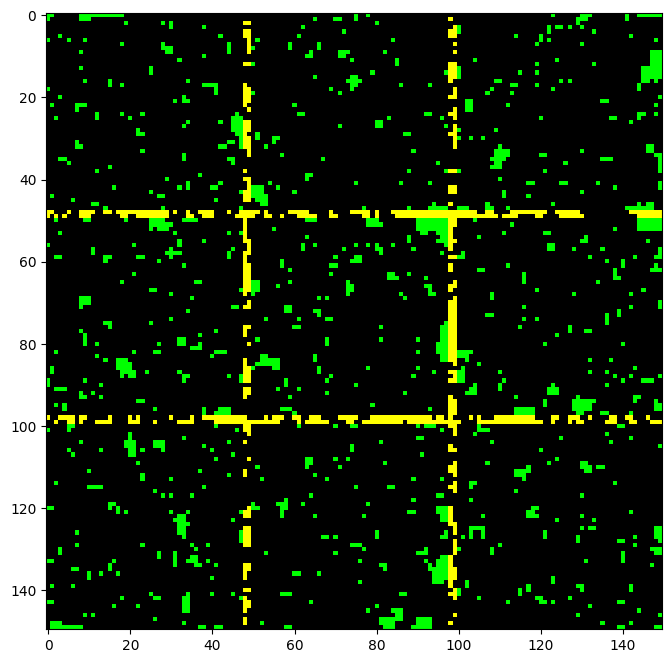

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.animation as animation

# set grid size
grid_size = 150
forest = np.zeros((grid_size, grid_size), dtype=int)

# generate random vegetation type: 0 for normal, 1 for fire-resistant
def generate_random_vegetation(grid_size, fire_resistant_percentage=0.3):
    vegetation_type = np.zeros((grid_size, grid_size), dtype=int)
    for i in range(grid_size):
        for j in range(grid_size):
            if np.random.rand() < fire_resistant_percentage:
                vegetation_type[i, j] = 1  # fire-resistant vegetation
            else:
                vegetation_type[i, j] = 0  # normal vegetation
    return vegetation_type

# generate cross vegetation type: 0 for normal, 1 for fire-resistant
def generate_cross_vegetation(grid_size):
    vegetation_type = np.zeros((grid_size, grid_size), dtype=int)
    for i in range(grid_size):
        for j in range(grid_size):
            if i % 2 == 0:
                vegetation_type[i, j] = 0  # normal vegetation
            else:
                vegetation_type[i, j] = 1  # fire-resistant vegetation
    return vegetation_type

# generate square form vegetation type: 0 for normal, 1 for fire-resistant
def generate_square_vegetation(grid_size):
    vegetation_type = np.zeros((grid_size, grid_size), dtype=int)
    square_size = grid_size // 3 
    fire_barrier_width = 2

    for i in range(3):
        for j in range(3):
            for x in range(i * square_size, (i + 1) * square_size):
                for y in range(j * square_size, (j + 1) * square_size):
                    vegetation_type[x, y] = 0

    for i in range(1, 3):
        for w in range(fire_barrier_width):
            vegetation_type[i * square_size - 1 - w, :] = 1
            vegetation_type[:, i * square_size - 1 - w] = 1

    return vegetation_type


# create a density matrix
def generate_density(grid_size, vegetation_type, normal_tree_density_range=(0.7, 0.8), fire_resistant_tree_density_range=(0.7, 0.8)):
    density = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            if vegetation_type[i, j] == 0:
                density[i, j] = np.random.uniform(*normal_tree_density_range)
            else:
                density[i, j] = np.random.uniform(*fire_resistant_tree_density_range)
    return density



# Generate vegetation type
vegetation_type = generate_square_vegetation(grid_size)

density = generate_density(grid_size, vegetation_type)

# Initialize forest state (0 for empty, 1 for burning, 2 for burned)
forest = np.zeros((grid_size, grid_size), dtype=int)

# Initialize position of ignition point
start_fire_x, start_fire_y = grid_size // 2, grid_size // 2  # Set ignition at the center
forest[start_fire_x, start_fire_y] = 1


# Combustion simulation
def update_forest(forest):
    new_forest = forest.copy()
    for i in range(grid_size):
        for j in range(grid_size):
            if forest[i, j] == 1:
                neighbors = [(i - 1, j), (i + 1, j), (i, j - 1), (i, j + 1)]
                for neighbor_x, neighbor_y in neighbors:
                    if 0 <= neighbor_x < grid_size and 0 <= neighbor_y < grid_size:
                        if forest[neighbor_x, neighbor_y] == 0:
                            base_probability = 0.8  # Set a fixed base probability
                            if vegetation_type[neighbor_x, neighbor_y] == 0:
                                spread_probability = base_probability * density[neighbor_x, neighbor_y]
                            else:
                                spread_probability = base_probability * density[neighbor_x, neighbor_y] * 0.5
                            if np.random.rand() < spread_probability:
                                new_forest[neighbor_x, neighbor_y] = 1
                new_forest[i, j] = 2  # Mark the current cell as burned
    return new_forest

# Create a colored grid based on vegetation type
def create_color_array(forest, vegetation_type):
    color_array = np.zeros((grid_size, grid_size, 3))  # Initialize a color array
    for i in range(grid_size):
        for j in range(grid_size):
            if forest[i, j] == 0:
                if vegetation_type[i, j] == 1:
                    color_array[i, j] = [1, 1, 0]  # Yellow for fire-resistant vegetation
                else:  # Normal vegetation
                    color_array[i, j] = [0, 1, 0]  # Green for normal vegetation
            elif forest[i, j] == 1:  # Burning
                color_array[i, j] = [1, 0, 0]  # Red for burning vegetation
            elif forest[i, j] == 2:  # Burned
                color_array[i, j] = [0, 0, 0]  # Black for burned area
            else:
                color_array[i, j] = [1, 1, 1]  # White for no vegetation
    return color_array

# Create images
fig, ax = plt.subplots(figsize=(8, 8))
color_array = create_color_array(forest, vegetation_type)
im = ax.imshow(color_array, interpolation='nearest')

# Set the limits of the color bar and remove it since we are not showing density
# plt.colorbar(im)  # This line is commented out because we are not using a color bar

def animate(step):
    global forest
    forest = update_forest(forest)
    color_array = create_color_array(forest, vegetation_type)
    im.set_array(color_array)

    if step in [0, 5, 10, 15, 20, 25, 50, 75, 90, 100, 110, 130, 150, 170, 190, 210, 250, 290]:
        plt.savefig(f"forest_fire_step_{step}.png")

    return [im]

# Create animation
ani = animation.FuncAnimation(fig, animate, frames=300, interval=200, blit=True)

# Display animation
from IPython.display import HTML
HTML(ani.to_jshtml())
